<a href="https://colab.research.google.com/github/miura-katsuyoshi/VerilogSimulation.ipynb/blob/main/VerilogSimulation_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt install iverilog

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  gtkwave
The following NEW packages will be installed:
  iverilog
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 1,811 kB of archives.
After this operation, 6,206 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 iverilog amd64 10.1-0.1build1 [1,811 kB]
Fetched 1,811 kB in 1s (2,086 kB/s)
Selecting previously unselected package iverilog.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../iverilog_10.1-0.1build1_amd64.deb ...
Unpacking iverilog (10.1-0.1build1) ...
Setting up iverilog (10.1-0.1build1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


## シミュレーション実行

以下のコードセルの `verilog_source = """` から `"""` の間に、Verilog ソースコードを貼り付け、実行してください。

initial ブロックの先頭で、 `$display` 関数を用いて、波形表示する信号名をコンマ区切りで表示するようにしてください。1カラム目は横軸のラベルになります。複数ビットの信号は、信号名の後に `*` を付けてください。

例）`$display("time [ns],clk,rst_n,data*,data[2],data[1],data[0]");`

`$monitor` 関数を用いて、波形表示する信号の値を表示するようにしてください。1カラム目は `$realtime` で時刻を表示してください。

例）`$monitor("%t,%b,%b,%d,%b,%b,%b", $realtime, clk, rst_n, data, data[2], data[1], data[0]);`

In [2]:
verilog_source = """
// Simple counter example
`timescale 1ns/1ns
module main;
  reg clk;
  reg rst_n;
  reg [2:0] data;

  initial begin
    $display("time [ns],clk,rst_n,data*,data[2],data[1],data[0]");
    $monitor("%t,%b,%b,%d,%b,%b,%b", $realtime, clk, rst_n, data, data[2], data[1], data[0]);
    rst_n <= 1'b0;
    repeat(2) @(posedge clk);
    rst_n <= 1'b1;
    repeat(10) @(posedge clk);
    $finish ;
  end

  initial clk <= 1'b1;
  always #5 clk <= ~clk;

  always @(posedge clk or negedge rst_n) begin
    if(~rst_n) data <= 8'd0;
    else begin
      if(data==3) data <= 3'bz;
      else if(data===3'bz) data <= 3'bx;
      else if(data===3'bx) data <= 3'b0;
      else data <= data + 1;
    end
  end
endmodule
"""

with open("main.v", "wt") as f:
  f.write(verilog_source)

!iverilog -o main main.v
!vvp main | tee graph.txt

time [ns],clk,rst_n,data*,data[2],data[1],data[0]
                   0,1,0,0,0,0,0
                   5,0,0,0,0,0,0
                  10,1,1,0,0,0,0
                  15,0,1,0,0,0,0
                  20,1,1,1,0,0,1
                  25,0,1,1,0,0,1
                  30,1,1,2,0,1,0
                  35,0,1,2,0,1,0
                  40,1,1,3,0,1,1
                  45,0,1,3,0,1,1
                  50,1,1,z,z,z,z
                  55,0,1,z,z,z,z
                  60,1,1,x,x,x,x
                  65,0,1,x,x,x,x
                  70,1,1,0,0,0,0
                  75,0,1,0,0,0,0
                  80,1,1,1,0,0,1
                  85,0,1,1,0,0,1
                  90,1,1,2,0,1,0
                  95,0,1,2,0,1,0
                 100,1,1,3,0,1,1
                 105,0,1,3,0,1,1
                 110,1,1,z,z,z,z


## グラフの描画

シミュレーションが実行できたら、以下のコードセルを実行してください。

`clk` は、遷移時間0で信号が変化します。`clk` 以外の信号は、`TRANSITION_TIME` の遷移時間で信号が変化します。但し、`TRANSITION_TIME` 未満の時間で次のイベントが生ずる場合は、次のイベントまでに信号が変化します。

クロック信号名を変えたい場合は、`CLOCK_NAME="clk"` を修正してください。信号変化時の遷移時間を変えたい場合は、`TRANSITION_TIME = 2.0` を修正してください。

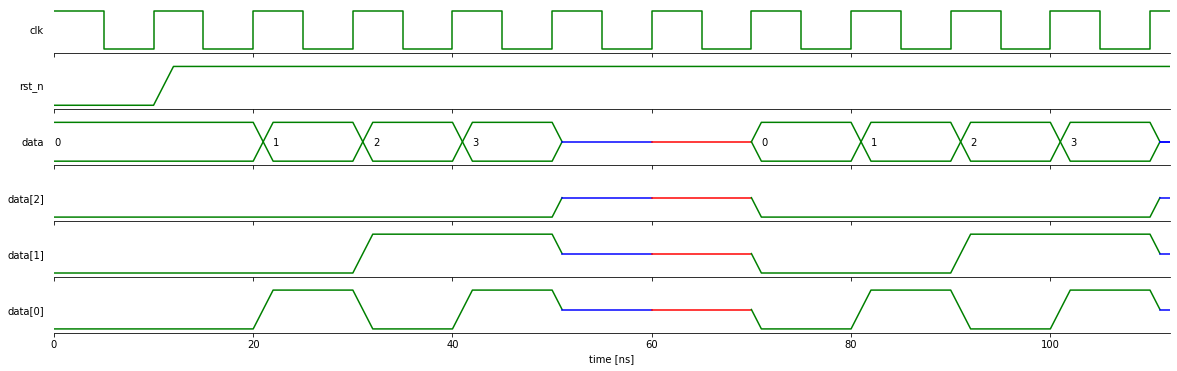

In [3]:
CLOCK_NAME="clk"      # クロック信号
TRANSITION_TIME = 2.0 # 遷移時間（立ち上がり時間、立ち下がり時間）但し、"clk" は常に遷移時間=0
                      # x/z<->0/1 の遷移は TRANSITION_TIME/2 (スロープを揃えるため）
LABEL_SEP = 1.0       # 信号名のラベル右端の表示位置。単位は時間軸単位
GRAPH_WIDTH = 20.0    # グラフの横幅（単位は時間軸単位ではない）
GRAPH_HEIGHT = 1.0    # グラフの高さ（波形１つ分）（単位は時間軸単位ではない）
GRAPH_COLOR = "green" # 波形の色（通常）
GRAPH_COLOR_X = "red" # 波形の色（X）
GRAPH_COLOR_Z = "blue"# 波形の色（Z）

import matplotlib.pyplot as plt

with open("graph.txt") as f:
  monitor_output = f.readlines()

while "" in monitor_output:
  monitor_output.remove("")
for i in range(len(monitor_output)):
  monitor_output[i] = monitor_output[i].split(',')
  for j in range(len(monitor_output[i])):
    monitor_output[i][j] = monitor_output[i][j].strip()
signal_names = monitor_output.pop(0)
is_multibit = [name[-1]=="*" for name in signal_names]
for j in range(len(signal_names)):
  if signal_names[j][-1]=="*":
    signal_names[j] = signal_names[j][0:-1]
num_signals = len(signal_names) - 1
for i in range(len(monitor_output)):
  monitor_output[i][0] = int(monitor_output[i][0])  # time

def plot_line(x, y):
  if y[0]=='x':
    color=GRAPH_COLOR_X
  elif y[0]=='z':
    color=GRAPH_COLOR_Z
  else:
    color=GRAPH_COLOR
  for i in range(len(y)):
    if y[i]=='x' or y[i]=='z':
      y[i] = 0.5
    else:
      y[i] = float(y[i])
  plt.plot(x, y, color=color)

def calc_transitioned_time(monitor_output, i, trans_time):
  cur_time = monitor_output[i][0]
  if i < len(monitor_output)-1:
    nex_time = monitor_output[i+1][0]
  else:
    nex_time = cur_time + trans_time
  if nex_time < cur_time + trans_time:
    return nex_time
  return cur_time + trans_time

plt.figure(figsize=(GRAPH_WIDTH, num_signals * GRAPH_HEIGHT))
for j in range(1,num_signals+1):
  if signal_names[j]==CLOCK_NAME:
    trans_time = 0
  else:
    trans_time = TRANSITION_TIME
  ax = plt.subplot(num_signals, 1, j)
  ax.yaxis.set_ticks([])
  ax.spines['left'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.text(-LABEL_SEP, 0.4, signal_names[j], horizontalalignment="right")
  ax.set_xlim(0.0, monitor_output[-1][0]+TRANSITION_TIME)
  ax.set_ylim(-0.1,1.1)
  if j < num_signals:
    plt.setp(ax.get_xticklabels(), visible=False)
  else:
    ax.set_xlabel(signal_names[0])
  x = [monitor_output[0][0]]
  if is_multibit[j] and monitor_output[0][j]!="x" and monitor_output[0][j]!="z":
    y0 = [0]
    y1 = [1]
    ax.text(0.0, 0.4, monitor_output[0][j])
  else:
    y0 = [monitor_output[0][j]]
    y1 = [monitor_output[0][j]]
  for i in range(1,len(monitor_output)):
    cur_time = monitor_output[i][0]     # current time
    pre_signal = monitor_output[i-1][j] # previous signal
    cur_signal = monitor_output[i][j]   # current signal
    if pre_signal != cur_signal:
      x.append(cur_time)
      y0.append(y0[-1])
      y1.append(y1[-1])
      if (pre_signal=='x' or pre_signal=='z') and (cur_signal!='x' and cur_signal!='z'):
        # x/z -> normal
        plot_line(x, y0)
        x = [cur_time, calc_transitioned_time(monitor_output, i, trans_time/2)]
        if is_multibit[j]:
          y0 = [0.5, 0]
          y1 = [0.5, 1]
          ax.text(x[-1], 0.4, cur_signal)
        else:
          y0 = [0.5, cur_signal]
          y1 = [0.5, cur_signal]
      elif  (pre_signal!='x' and pre_signal!='z') and (cur_signal=='x' or cur_signal=='z'):
        # normal -> x/z
        x.append(calc_transitioned_time(monitor_output, i, trans_time/2))
        y0.append(0.5)
        y1.append(0.5)
        plot_line(x, y0)
        if is_multibit[j]:
          plot_line(x, y1)
        x = [calc_transitioned_time(monitor_output, i, trans_time/2)]
        y0 = [cur_signal]
        y1 = [cur_signal]
      elif  (pre_signal=='x' or pre_signal=='z') and (cur_signal=='x' or cur_signal=='z'):
        # x->z / z->x
        plot_line(x, y0)
        x = [cur_time]
        y0 = [cur_signal]
        y1 = [cur_signal]
      else:
        # normal -> normal
        x.append(calc_transitioned_time(monitor_output, i, trans_time))
        if is_multibit[j]:
          y0.append(1 - float(y0[-1]))
          y1.append(1 - float(y1[-1]))
          ax.text(x[-1], 0.4, monitor_output[i][j])
        else:
          y0.append(cur_signal)
          y1.append(cur_signal)
  x.append(monitor_output[-1][0] + TRANSITION_TIME)
  y0.append(y0[-1])
  y1.append(y1[-1])
  plot_line(x, y0)
  if is_multibit[j] and y0[-1]!='x' and y0[-1]!='z':
    plot_line(x, y1)

plt.show()
# plt.savefig("waveform.svg", format="svg")   # グラフをPNG形式で保存したい場合は、plt.show() をコメントアウトし、この行を有効に
# plt.savefig("waveform.png", format="png")   # グラフをSVG形式で保存したい場合は、plt.show() をコメントアウトし、この行を有効に
